# **Daltix Data Analyst Challenge**
In this challenge you will explore a subset of data that mirrors (in a simplified manner) some of the data we work with at Daltix.  
The goal of this challenge is to explore the data we provide and share all insights you find relevant in a business-friendly manner.
  
Some tips:
* Imagine you are presenting these to both technical and non-technical members of your company. 
* Take into consideration that the code you produce should be readable and reusable by a colleague in the future.


**Good luck** 😀

> The Daltix Team
______________

Owner: Sofia Vaz - Date: 2019-11-05

Python version: 3.7.4 - Conda version: 4.7.12 - Jupyter Notebook version: 6.0.1

In [ ]:
import pandas as pd
import pandasql as ps
import numpy as np
import matplotlib.pyplot as plt

______________
## 1. Extract the data
**Description**

In this section you will focus on importing the files from the dataset that was provided and do a simple QA of the data.
  
After completing it you should be have all 4 tables locally available.

_Question:_
* Did you notice any quality issues with the files we provided? If so, can you list them? How did you deal with them? 

### Import Tables & Tables Overview

In [2]:
## Import Tables:
product_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/product.csv', sep=',', skip_blank_lines=True)
price_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/price.csv', sep=',', skip_blank_lines=True)
category_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/category.csv', sep='|', skip_blank_lines=True)
promo_tab = pd.read_csv ('C:/Users/Vaz/Desktop/DALTIX/promo.csv', sep=',', skip_blank_lines=True)

In [3]:
## Tables Overview:

#product_tab.head()
#product_tab.describe(include='all')
#price_tab.head()
#price_tab.describe(include='all')
#category_tab.head()
#category_tab.describe(include='all')
#promo_tab.head()
#promo_tab.describe(include='all')


## Chech columns types:

#product_tab.info()
#price_tab.info()
#category_tab.info()
#promo_tab.info()


## Number of null entries per category:

#product_tab.isnull().sum()
#price_tab.isnull().sum()
#category_tab.isnull().sum()
#promo_tab.isnull().sum()


## Find Duplicate Rows:

#product_tab_norep = product_tab.drop_duplicates(keep='first')
#print('Product Table has ' + str(len(product_tab) - len(product_tab_norep)) + ' duplicate rows')
#price_tab_norep = price_tab.drop_duplicates(keep='first')
#print('Price Table has ' + str(len(price_tab) - len(price_tab_norep)) + ' duplicate rows')
#category_tab_norep = category_tab.drop_duplicates(keep='first')
#print('Category Table has ' + str(len(category_tab) - len(category_tab_norep)) + ' duplicate rows')
#promo_tab_norep = promo_tab.drop_duplicates(keep='first')
#print('Promo Table has ' + str(len(promo_tab) - len(promo_tab_norep)) + ' duplicate rows')


## Find Unique Values Per Column:

#print(product_tab.shop.unique())
#print(product_tab.country.unique())
#print(list(product_tab.brand.sort_values().unique()))
#print(list(product_tab.name.sort_values().unique()))

#print(price_tab.shop.unique())
#print(price_tab.country.unique())
#print(price_tab.location.unique())
#print(price_tab.unit_std.unique())

#print(category_tab.shop.unique())
#print(category_tab.country.unique())
#print(list(category_tab.categories.sort_values().unique()))

### 1.1 - Product Table

##### Main Issues Detected

- Duplicate rows: 41

- Column "country" - lacks standardisation ('be' is different from 'be   ')

- Column "brand" - lacks standardisation (upper/lowercase; ®)
    - e.g.1: 'ALPRO' vs. 'ALPRO®'
    - e.g.2: 'ALPRO' vs. 'Alpro' 

- Column "name" - lacks standardisation (upper/lowercase) 

##### Clean Table

In [4]:
## Eliminate duplicate rows:
product_tab = product_tab.drop_duplicates(keep='first')

## Standardize "country":
product_tab.loc[product_tab.country.str.contains('be'), 'country'] = 'be'
product_tab.loc[product_tab.country.str.contains('nl'), 'country'] = 'nl'

## Standardize categorical vars:
product_tab['name'] = product_tab['name'].str.lower()
product_tab['brand'] = product_tab['brand'].str.lower()
product_tab.brand = product_tab.brand.apply(lambda x: x.replace('®', '') if isinstance(x, str) else x)
product_tab['contents'] = product_tab['contents'].str.lower()

### 1.2 - Price Table

##### Main Issues Detected

- Duplicate rows: 1649

- Column "price" - highly scattered, with outliers. Some outliers were removed in this section. There are still weird prices that will be analized in section 3.5.

- Column "price" is also a numerical category, with NaN values. These rows need to be deleted.

##### Clean Table

In [5]:
## Eliminate duplicate rows:
price_tab = price_tab.drop_duplicates(keep='first')

## Eliminate rows with NaN values in 'price' column:
price_tab = price_tab.dropna(axis=0, subset=['price'])

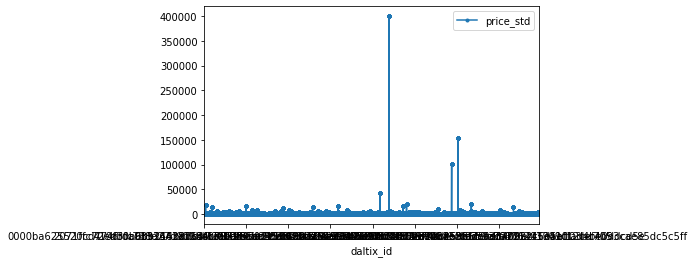

In [6]:
## Check for outliers:

## Check for outliers visually by finding the standard deviation by 'daltix_id':
find_outliers_tab = price_tab[['daltix_id', 'location', 'price', 'date']].copy().drop_duplicates(keep='first')
stdeviations = find_outliers_tab.groupby('daltix_id').std()

## Add price standard deviation as 'price_std' to the table 'find_outliers_tab' and 'price_tab':
stdeviations.columns = stdeviations.columns + '_std'
find_outliers_tab = pd.merge(find_outliers_tab, stdeviations.price_std, how='outer', on=['daltix_id'])
price_tab = pd.merge(price_tab, stdeviations.price_std, how='outer', on=['daltix_id'])

## Plot 'price_std' per 'daltix_id':
find_outliers_tab.plot(x="daltix_id", y="price_std", marker='.')

In [7]:
## Define metrics to delete outliers:

## See different price entries introduced per daltix_id:
find_outliers_tab.groupby('daltix_id')['price'].unique()

## Find number of unique price entries per daltix_id:
price_per_daltix_id = find_outliers_tab[['daltix_id', 'price']].copy().drop_duplicates(keep='first')
price_nrprices_tab = price_per_daltix_id.groupby('daltix_id')['price'].count().to_frame('nr_prices').reset_index()
price_nrprices_tab.sort_values(by='daltix_id')

## Are any prices wrongly introduced/registered? See the number of price entries per different 'price' per 'daltix_id':
daltix_ids = find_outliers_tab.daltix_id.unique()
price_entries_tab = find_outliers_tab.groupby(['daltix_id', 'price'])['price'].count().to_frame('price_entries').reset_index()
price_entries_tab.sort_values(by='daltix_id')

## Add 'price_entries' column and 'nr_prices' to price_tab:
price_tab_2 = pd.merge(price_tab, price_entries_tab, how='outer', on=['daltix_id', 'price'])
price_tab_3 = pd.merge(price_tab_2, price_nrprices_tab, how='outer', on=['daltix_id'])

## Change 'price_entries' and 'nr_prices' columns into integers:
price_tab_3.price_entries = price_tab_3.price_entries.astype(int)
price_tab_3.nr_prices = price_tab_3.nr_prices.astype(int)

## Eliminate Outliers - vals introduced <=3x when >1 prices have been introduced for a particular 'daltix_id':
outliers = price_tab_3[(price_tab_3.nr_prices>1) & (price_tab_3.price_entries<=3)]
price_tab_outliersfree = price_tab_3[~((price_tab_3.nr_prices>1) & (price_tab_3.price_entries<=3))]

## Check:
#pd.set_option('display.max_rows', price_tab_outliersfree.shape[0]+1)
#price_tab_outliersfree[price_tab_outliersfree.product_id.isin(['S2019080600288050000'])].sort_values(by='price')

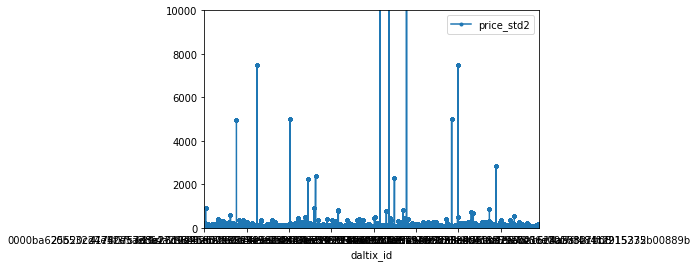

In [8]:
## Check for outliers after first metrics was applied:

## Check for outliers a second time visually by finding the standard deviation by 'daltix_id':
find_outliers_tab = price_tab_outliersfree[['daltix_id', 'location', 'price', 'date']].copy().drop_duplicates(keep='first')
stdeviations = find_outliers_tab.groupby('daltix_id').std()

## Add price standard deviation as 'price_std' to the table 'find_outliers_tab':
stdeviations.columns = stdeviations.columns + '_std2'
find_outliers_tab = pd.merge(find_outliers_tab, stdeviations.price_std2, how='outer', on=['daltix_id'])
price_tab = pd.merge(price_tab, stdeviations.price_std2, how='outer', on=['daltix_id'])
#price_tab_outliersfree = pd.merge(price_tab_outliersfree, stdeviations.price_std2, how='outer', on=['daltix_id']) APAGAR

## Plot 'price_std' per 'daltix_id':
find_outliers_tab.plot(x="daltix_id", y="price_std2", marker='.', ylim=[0,10000])

### 1.3 - Category Table

##### Main Issues Detected
- Field "categories" - separate into 'main_category', 'sub_category_1', 'sub_category_2'

- Field 'main_category' - has different levels of main category (promotion category is very different from a product type category). Only shop1 has main categories that are not product type, and all shop1's  main categories are not product type.
    - e.g.1: 'Aanbiedingen' vs. 'Dranken'
    
- Field "main_category" - lacks standardisation
    - e.g.1: 'Wijn & Bubbels' vs. 'Wijn en Bubbels'
    - e.g.2: 'Brood / Ontbijt' vs. 'Brood/Ontbijt'
    

##### Clean Table

In [9]:
## Standardize column 'categories' in category_tab:
category_tab['categories'] = category_tab['categories'].str.lower()
category_tab.categories = category_tab.categories.apply(lambda x: x.replace(' / ', '/') if isinstance(x, str) else x)
category_tab.categories = category_tab.categories.apply(lambda x: x.replace('&', 'en') if isinstance(x, str) else x)
category_tab.categories = category_tab.categories.apply(lambda x: x.replace('  ', ' ') if isinstance(x, str) else x)

## Split 'categories' column into 3 columns (n=2):
category_split = category_tab["categories"].str.split(",", n = 2, expand = True) 

## Clean each new column by selecting text between "":
category_split_0 = category_split[0].str.split("\"", n = 2, expand = True)
category_split_1 = category_split[1].str.split("\"", n = 2, expand = True)
category_split_2 = category_split[2]

## Give new columns the names 'main_category', 'sub_category_1', 'subsub_categories', and add them to 'category_tab' table:
category_tab["main_category"]= category_split_0[1]
category_tab["sub_category_1"]= category_split_1[1]
category_tab["subsub_categories"]= category_split_2

## Analyze each shop categories:
#category_tab.main_category[category_tab.shop == 'shop1'].value_counts().plot.pie()
#print(category_tab.main_category[category_tab.shop == 'shop1'].sort_values().unique())

## Separate category data from shop1 to a different table (category_tab_shop1):
category_tab_shop1 = category_tab[category_tab.shop == 'shop1'].copy()
category_tab = category_tab[category_tab.shop != 'shop1'].copy()

### 1.4 - Promo Table

##### Main Issues Detected

- Field "dlevel" - highly scattered

    - Most discount values were in the [0,1] range. However, some instances were in the [0,100] range (probably introduced as percentages). These values were normalized and used in the analysis.
    
    - Discounts over 0.75 do not exist, as expected and only one item from shop3 has dlevels over 0.5, in both 'ledeberg' and 'ans' locations.

##### Clean Table

In [10]:
## Check unique discount values 'dlevel':
promo_tab.dlevel.sort_values().unique()

## Check number of discount values > 1 (these were probably introduced as percentages):
promo_tab[promo_tab.dlevel > 1]

## Normalize dlevels introduced as percentages:
promo_tab.loc[promo_tab['dlevel'] > 1, 'dlevel'] = promo_tab['dlevel'] * 0.01

## Does the maximum dlevel make sense? Over 0.5 is a very big discount.
#promo_tab[promo_tab.dlevel > 0.5]

In [ ]:
# code here

_____________________
## 2. Explore the dataset

**Requirements:**
Use `pandasql` to query the tables and explore the dataset

**Description**

In this section you are free to explore the data however you like in order get to know your dataset. It's meant to be exploratory and only for you to get familiar with the data.

At the end of this section you should be able to, at least, answer the following questions:
* For which time interval you have prices for?
* How many shops are comprised in the dataset?
* How many different products are there per shop in the dataset?
* Can a product have more than 1 active promotion at the same time? 

You are free (and __encouraged__) to further describe the dataset as you see fit.

In [11]:
def pysqldf(query):
 return ps.sqldf(query, globals())

### 2.1 - For which time interval you have prices for?

- From 2019-08-01 until 2019-10-15

Owner Note: It was necessary to use pandas due to large file dimensions. Otherwise PC would crash.


In [12]:
## USING PANDASQL: 

#q_sort_price_date = """
#SELECT DISTINCT price, date
#FROM price_tab
#WHERE price AND date IS NOT NULL
#ORDER BY [date];
#"""
#sort_price_date = pysqldf(q_sort_price_date)
#print(sort_price_date.head())
#print(sort_price_date.tail())

In [13]:
## USING PANDAS: 

#price_tab.sort_values(by='date')
print("ti: " + str(price_tab.date.min()))
print("tf: " + str(price_tab.date.max()))

ti: 2019-08-01
tf: 2019-10-15


### 2.2 - How many shops are comprised in the dataset?

- Product/Price Tables: 4 shops (Shop1, Shop2, Shop3, Shop4)
- Promo Table: 3 shops (Shop2, Shop3, Shop4)
- Category Table: 3 shops (Shop2, Shop3, Shop4) + Shop1, previously eliminated from this table

Owner Note: It was necessary to use pandas for the price file, due to large file dimensions. Otherwise PC would crash.


In [14]:
## USING PANDASQL: 

    ## Product Dataset
q_nr_shops_product_tab = """
SELECT DISTINCT product_tab.shop
FROM product_tab;
"""
print("Nr of shops in Product Table: " + str(len(pysqldf(q_nr_shops_product_tab))))
#print(pysqldf(q_nr_shops_product_tab).sort_values(by='shop'))

    ## Category Dataset
q_nr_shops_category_tab = """
SELECT DISTINCT category_tab.shop
FROM category_tab;
"""
print("Nr of shops in Category Table: " + str(len(pysqldf(q_nr_shops_category_tab))))
#print(pysqldf(q_nr_shops_category_tab).sort_values(by='shop'))

    ## Promo Dataset
q_nr_shops_promo_tab = """
SELECT DISTINCT promo_tab.shop
FROM promo_tab;
"""
print("Nr of shops in Promo Table: " + str(len(pysqldf(q_nr_shops_promo_tab))))
#print(pysqldf(q_nr_shops_promo_tab).sort_values(by='shop'))

    ## Price Dataset
#q_nr_shops_price_tab = """
#SELECT DISTINCT price_tab.shop
#FROM price_tab;
#"""
#print("Nr of shops in Price Table: " + str(len(pysqldf(q_nr_shops_price_tab))))

Nr of shops in Product Table: 4
Nr of shops in Category Table: 3
Nr of shops in Promo Table: 3


In [15]:
## USING PANDAS: 

    ## Price Dataset
nr_shops_price_tab = price_tab.shop.unique()

print("Nr of shops in Price Table: " + str(len(nr_shops_price_tab)))
#print(sorted(price_tab.shop.unique()))

Nr of shops in Price Table: 4


### 2.3 - How many different products are there per shop in the dataset?

##### 2.3 - Main Issues Detected

- Question: Is there a unique product_id for each daltix_id?

    - Answer: NO. There are more daltix_ids than product_ids.
        - Is it because daltix_id(product_id, shop, country)? Does this happen only when the shop is in > 1 country? YES
        
(See code below)

In [16]:
shops = product_tab.shop.sort_values().unique()

## Print unique values per shop, to understant if there is overlap between identifying variables:

print('\nUnique Entries:') 
print('Shops \t country \t daltix_id \t product_id \t name') 
for i in range(len(shops)):
    print(str(shops[i]) + '\t' + str(len(product_tab.country[product_tab.shop == shops[i]].unique())) +
          '\t\t' + str(len(product_tab.daltix_id[product_tab.shop == shops[i]].unique())) +
          '\t\t' + str(len(product_tab.product_id[product_tab.shop == shops[i]].unique())) +
          '\t\t' + str(len(product_tab.name[product_tab.shop == shops[i]].unique())))
    
print('\nUnique daltix_ids per table:')
print('Shop \t Product_tab \t Price_tab \t Promo_tab \t Category_tab')
for i in range(len(shops)):
    print(str(shops[i]) + ' \t ' +  str(len(product_tab.daltix_id[product_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(price_tab.daltix_id[price_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(promo_tab.daltix_id[promo_tab.shop == shops[i]].unique())) + '\t\t' +
          str(len(category_tab.daltix_id[category_tab.shop == shops[i]].unique())))


Unique Entries:
Shops 	 country 	 daltix_id 	 product_id 	 name
shop1	2		2010		1896		1901
shop2	1		6		6		6
shop3	1		807		807		794
shop4	1		1369		1369		1363

Unique daltix_ids per table:
Shop 	 Product_tab 	 Price_tab 	 Promo_tab 	 Category_tab
shop1 	 2010		5487		0		0
shop2 	 6		17996		3		4
shop3 	 807		9432		115		593
shop4 	 1369		17788		232		765


- Question: Can a shop have >1 products associated to the same product_id?

    - Answer: YES. There are products within a shop with the same product_id that are very different products and have a different name! This can happen if the shop exists in different countries. In this case the variable "daltix_id" solves it. (e.g.2.3.1)
    

- Question: Can different shops have  products associated to the same product_id?

    - Answer: YES. There are products from different shops that have the same product_id. They might even be similar products with names written slightly differently. In this case it does not affect the product count per shop. (e.g.2.3.2)
    
    
- Question: Can a shop have >1 products with the same name identified with different product_id's?

    - Answer: YES. There are products within a shop with the same name that have different product_ids (both in the same country and in different countries)! In these cases the same product can be considered >1 time. (e.g.2.3.3 and e.g.2.3.4)
    
(See code below)   

In [17]:
shops = product_tab.shop.sort_values().unique()
shop_assortment = product_tab[['shop', 'country', 'product_id', 'name']].copy().drop_duplicates(keep='first')

## Find examples of duplicate product_ids: 
duplicate_product_id = pd.concat(g for _, g in shop_assortment.groupby("product_id") if len(g) > 1)
duplicate_names = pd.concat(g for _, g in shop_assortment.groupby("name") if len(g) > 1)

print('\nExample 2.3.1: ')
print(duplicate_product_id[duplicate_product_id.product_id == '1270'])

print('\nExample 2.3.2: ')
print(duplicate_product_id[duplicate_product_id.product_id == '10315'])

print('\nExample 2.3.3: ')
print(duplicate_names[duplicate_names.name == 'aardappelsalade 500g'])

print('\nExample 2.3.4: ')
print(duplicate_names[duplicate_names.name == 'advocaat'])


Example 2.3.1: 
      shop country product_id                name
455  shop1      be       1270    hondenpoepzakjes
547  shop1      nl       1270  italiaanse burgers

Example 2.3.2: 
       shop country product_id                                      name
307   shop3      be      10315       boni s. fruitcockt.lichte sir. blik
1390  shop4      be      10315  boni s. fruitcockt.lichte sir. blik 227g

Example 2.3.3: 
       shop country product_id                  name
249   shop4      be      10288  aardappelsalade 500g
1445  shop4      be      29189  aardappelsalade 500g

Example 2.3.4: 
       shop country product_id      name
585   shop1      nl       1131  advocaat
1848  shop1      be       4237  advocaat


In [18]:
## USING PANDASQL: 

    ## Shop1:
q_products_shop1 = """
SELECT COUNT(DISTINCT daltix_id)
FROM product_tab
WHERE shop ='shop1';
"""
print('Product Table - shop1:\n' + str(pysqldf(q_products_shop1)))

    ## Shop2:
q_products_shop2 = """
SELECT COUNT(DISTINCT daltix_id)
FROM product_tab
WHERE shop ='shop2';
"""
print('Product Table - shop2:\n' + str(pysqldf(q_products_shop2)))

    ## Shop3:
q_products_shop3 = """
SELECT COUNT(DISTINCT daltix_id)
FROM product_tab
WHERE shop ='shop3';
"""
print('Product Table - shop3:\n' + str(pysqldf(q_products_shop3)))

    ## Shop4:
q_products_shop4 = """
SELECT COUNT(DISTINCT daltix_id)
FROM product_tab
WHERE shop ='shop4';
"""
print('Product Table - shop4:\n' + str(pysqldf(q_products_shop4)))

Product Table - shop1:
   COUNT(DISTINCT daltix_id)
0                       2010
Product Table - shop2:
   COUNT(DISTINCT daltix_id)
0                          6
Product Table - shop3:
   COUNT(DISTINCT daltix_id)
0                        807
Product Table - shop4:
   COUNT(DISTINCT daltix_id)
0                       1369


### 2.4 - Can a product have more than 1 active promotion at the same time?

- YES. A product from a specific shop can have different promotions at different locations and at the same location! (e.g.2.4.1)

In [19]:
## USING PANDASQL:

# Item simultaneous promotions at a specific shop at a specific location:
q_simultaneous_promos = """
SELECT COUNT (DISTINCT promo_type) AS promo_nr
FROM promo_tab
GROUP BY daltix_id, date, shop, location
ORDER BY promo_nr DESC;
"""

print('Maximum number of simultaneous promotions:')
print(pysqldf(q_simultaneous_promos).max())

Maximum number of simultaneous promotions:
promo_nr    2
dtype: int64


In [20]:
## Extra Check 1 USING PANDAS:

promo_tab_2 = promo_tab.copy()

# Product simultaneous promos: a new field is required (daltix_id + date)
promo_tab_2['daltix_id_date'] = promo_tab_2['daltix_id'] + '_' + promo_tab_2['date']
simultaneous_promo = promo_tab_2.groupby('daltix_id_date')['promo_type'].count().to_frame('nr_promos').reset_index()
print(simultaneous_promo.nr_promos.unique())
simultaneous_promo_ids = list(simultaneous_promo.daltix_id_date[simultaneous_promo.nr_promos == 4])

# This reflects different types of promotions with different dlevels, at different location:
print('Example 2.4.1:')
promo_tab_2[promo_tab_2['daltix_id_date'].isin(simultaneous_promo_ids[0:1])].sort_values(by='date')

[1 2 4]
Example 2.4.1:


,daltix_id,shop,country,location,promo_type,dlevel,date,daltix_id_date
1279,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...,shop3,be,ledeberg,Price cut with Multibuy Condition,0.357143,2019-08-27,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...
2617,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...,shop3,be,ans,Price cut with Multibuy Condition,0.251256,2019-08-27,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...
2844,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...,shop3,be,ledeberg,Price cut,0.714286,2019-08-27,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...
4177,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...,shop3,be,ans,Price cut,0.502513,2019-08-27,f2e5afe8ce05318fd548adb4bd96eb783e1b85b0e6d682...


##### 2.4 - Main Issues Detected

- Rounding of the variable 'dlevel' issue (e.g.2.4.2)

(see code below)

In [21]:
## Extra Check 2 USING PANDAS:

# Product simultaneous promos at a specific shop at a specific location:
promo_tab_2['daltix_id_date_shop_location'] = promo_tab_2['daltix_id'] + '_' + promo_tab_2['date'] + '_' + promo_tab_2['shop'] + '_' + promo_tab_2['location']
simultaneous_promo = promo_tab_2.groupby('daltix_id_date_shop_location')['promo_type'].count().to_frame('nr_promos').reset_index()
print(simultaneous_promo.nr_promos.unique())
simultaneous_promo_ids = list(simultaneous_promo.daltix_id_date_shop_location[simultaneous_promo.nr_promos == 2])

# This reflects different types of promotions:
promo_tab_2[promo_tab_2['daltix_id_date_shop_location'].isin(simultaneous_promo_ids[35:36])].sort_values(by='date')

# This reflects round(dlevel) issue:
print('Example 2.4.2:')
promo_tab_2[promo_tab_2['daltix_id_date_shop_location'].isin(simultaneous_promo_ids[0:1])].sort_values(by='date')

[1 2]
Example 2.4.2:


,daltix_id,shop,country,location,promo_type,dlevel,date,daltix_id_date,daltix_id_date_shop_location
1964,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...,shop2,be,base,Price cut with Multibuy Condition,0.333333,2019-09-12,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...
4014,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...,shop2,be,base,Price cut with Multibuy Condition,0.330000,2019-09-12,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...,5be2f8a50a96c70e003b80e3d2b80e4209fa5cf57b0843...


In [22]:
## Round discount level:
promo_tab.dlevel = promo_tab.dlevel.round(2)

## Eliminate duplicate rows:
promo_tab = promo_tab.drop_duplicates(keep='first')

In [ ]:
# code here

___________________________
## 3 Transformation & Manipulation

__Description__

In this section you should use the tables provided in the dataset and manipulate them to find valuable business insights.

Some questions you should be able to answer:
* Which shops have a bigger overlap in their assortment?
* Which shop has the overall cheapest assortment? What about cheapest categories?
* Which shop is the "_king_" of promotions?
* Where would you do your shopping? When? Why?
* Can you spot any weird price behaviour? 

The questions above are just some example questions. You should provide any insights you find useful/relevant.

_Note:_
* Use this section as a prepation for the next!

In [ ]:
# code here

___________________
## 4. Visualization

__Description__

Imagine you are presenting the insights you found to your team, which include fellow data analysts, data scientists and business colleagues.

Present your findings on the insights you've discovered so far. 

In [ ]:
# code here

___________________
## 5. Discussion

__Description__

Take some time to prepare some up-coming questions!

* If given more time, how would you further refine your analysis? 
* What other information would you like to have to provide more valuable insigths?

#### ANSWER HERE
> ...

___________________
## 6. Bonus question

__Description__

You now have access to the nutritional values of some products:
* **nutri_tbl.csv** - https://daltix-public-interviews.s3-eu-west-1.amazonaws.com/data-analyst-challenge/nutri.csv

Assuming that you have to consume between 2200 kcal and 2700 kcal per day, build a basket of 15 products for a [ketogenic diet](https://en.wikipedia.org/wiki/Ketogenic_diet). Where can we buy that basket for the cheapest price? 

__IMPORTANT__:
This is an extra question that you should only focus one if you have time. 
We will only consider your answer if you solved all the previous sections.

In [ ]:
# code here